In [1]:
# Importing necessary libraries for data manipulation, NLP, and visualization
import pandas as pd  # Importing pandas for data manipulation
import numpy as np  # Importing numpy for numerical operations
import re  # Importing re for regular expressions
import dask  # Importing dask for parallel computing
dask.config.set({'dataframe.query-planning': True})  # Configuring dask for query planning
import dask.dataframe as dd  # Importing dask dataframe for big data processing
from collections import Counter

# NLP Libraries
from nltk.corpus import stopwords  # Importing NLTK's stopwords
import nltk
from nltk.corpus import wordnet
nltk.download('punkt') # Downloads the NLTK data necessary for word tokenization
nltk.download('averaged_perceptron_tagger') # Downloads the NLTK data required for part-of-speech tagging using the averaged perceptron algorithm
nltk.download('wordnet') # Downloads the WordNet database, a lexical database of English words and their semantic relationships
nltk.download('stopwords') # Downloading it manually cause importing stopwork doesn't work for me (Anthony)
from nltk.stem import WordNetLemmatizer
import spacy  # Importing spaCy for advanced NLP tasks
from nltk.tokenize import RegexpTokenizer  # Importing RegexpTokenizer for tokenization
from gensim.models import Phrases  # Importing Phrases for phrase modeling
from gensim.corpora import Dictionary  # Importing Dictionary for building corpora
from gensim.models.ldamulticore import LdaMulticore  # Importing LdaMulticore for topic modeling
from nltk.probability import FreqDist  # Importing FreqDist for frequency distribution
from gensim.parsing.preprocessing import remove_stopwords  # Importing remove_stopwords for preprocessing
from gensim.models import CoherenceModel # Compute topic coherence
from gensim.models import LdaModel

# Visualisation Libraries
import matplotlib.pyplot as plt  # Importing matplotlib for basic visualization
from plotly.subplots import make_subplots  # Importing make_subplots for subplots
import seaborn as sns  # Importing seaborn for advanced visualization
import pyLDAvis  # Importing pyLDAvis for topic visualization
import pyLDAvis.gensim


# Setting matplotlib style
plt.style.use('ggplot')



# Setting seaborn context for paper
sns.set_context('paper')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ameerul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ameerul\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ameerul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ameerul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import requests

In [3]:
username = "GreyScaling"
repo_name = "UOB-Financial-Loan-Analysis"

# Specify the folder path (e.g., "path/to/folder")
folder_path = "csvs"

In [4]:
def get_filenames(username , repo_name , folder_path):

    '''

    Takes in the github credentials and returns the csv filenames within the folder given
    
    Parameters: 
        username (str): GitHub Username
        repo_name (str): User's Repository Name
        folder_path (str): The folder path containing the csv files
           
    Returns:

        filenames (list) : Returns a list of csv folderpaths    
     '''

    url = f"https://api.github.com/repos/{username}/{repo_name}/contents/{folder_path}"
    csv_path = f'https://raw.githubusercontent.com/{username}/{repo_name}/main/{folder_path}/'


    filenames = []
    response = requests.get(url)

    #Checks if the url is OK
    if response.status_code == 200:
        data = response.json()
        for item in data:
            # Check if the item is a file and ends with ".csv" extension
            if item["type"] == "file" and item["name"].endswith(".csv"):

                #Attach the folder path together with the filename get the entire url  
                filename = csv_path + item['name']
                filenames.append(filename)
    else:
        print(f"Error: {response.status_code}")

    return(filenames)

In [5]:
csvs = get_filenames(username , repo_name , folder_path)

In [6]:
#Read all the files into a single dataframe
df = dd.read_csv(csvs).compute().reset_index(drop=True)

In [7]:
# Check for duplicate rows based on all columns
df[df.duplicated(keep=False)]
df.drop_duplicates(inplace=True , keep='last')

In [8]:
#Remove any row that has no content 
df = df[df['Content'].str.strip() != '']
#Remove any null Rows 
df.dropna(inplace =True)

In [9]:
def pre_process(dataframe):
    '''
    This Function performs the pre-processing of the dataframe 

    args:
        dataframe: The dataframe to be preprocessed
    
    Functions:
        
        the following are the steps taken to proprocess the data

        1) Lower case tranformation
        2) Removing Punctuations
        3) Removing Stopwords
        4) Removing Numbers
        5) Removing single alphabets
        6) Removing Hyperlinks
        7) Removing WhiteSpace


    '''
    
    #converts text to lowercase
    dataframe['Content'] = dataframe['Content'].apply(lambda x: x.lower())

    #Remove all punctuations
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

    #Remove all stopwords
    stop_words = stopwords.words('english')

    ## Adding additonal words to be removed
    additional_words = ['from', 'singapore', 'malaysia' , 'said' ,',' , 'oil' , 'gas' , 'healthcare' , 
                        'health' , 'bank' , 'real estate' , 'media' , 'million' , 'billion','market' , 
                        'sector' , 'also' , 'year' , 'natural' , 'earnings' , 'income' , 'financial' ,
                        'industry' , 'per' , 'cent' , 'construction'  , 'company' , 'help' , 'pay'
                        , 'use' , 'group' , 'new' , 'say' , 'manager' , 'patient' , 'run' , 'call',
                        'take' , 'people' , 'check' , 'even' , 'european' , 'eye' , 'non' , 'find', 
                        'real' , 'estate' , 'vehicle' , 'japan' , 'korea' , 'asian' ,'asean' , 'insurance',
                        'corporation' , 'technology' , 'industrial' , 'logistics','consumer' , 'goods' , 'property'
                        ]
    
    stop_words.extend(additional_words)
    dataframe['Content'] = dataframe['Content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

    #Removing Numbers
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub(r'\d+' , '' , x))

    #remove single alphabets
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub(r'\b[a-zA-Z]\b', ' ' , x))

    #remove Hyperlinks
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub(r"<.*?>+|https?://\S+|www\.\S+", " " , x))

    #Removing extra white spaces
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub(r"^\s+|\s+$|\s+(?=\s)", "" , x))


https://spacy.io/usage/models

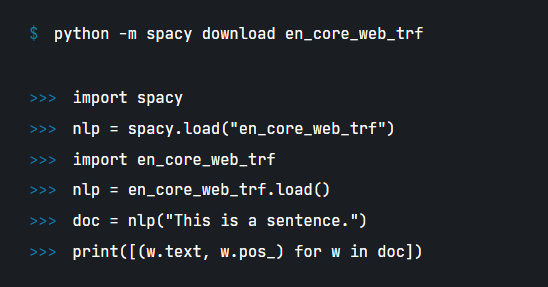

In [10]:
pre_process(df)

In [11]:
# Load the English language model in spaCy with certain components disabled
nlp = spacy.load('en_core_web_trf', disable=['parser', 'ner'])

In [12]:
def lemmatize_text(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    '''
    Lemmatize the text using spaCy.

    Args:
    - text: The input text to be lemmatized.
    - allowed_postags: A list of allowed part-of-speech tags for lemmatization.

    Returns:
    - A string of lemmatized tokens joined by space.
    '''

    # Process the text with spaCy
    doc = nlp(text)

    # Extract lemmatized tokens based on allowed part-of-speech tags
    lemmatized_tokens = [token.lemma_ for token in doc if token.pos_ in allowed_postags]

    # Join the lemmatized tokens into a string
    return ' '.join(lemmatized_tokens)

In [13]:
# # Initialize the WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()

# # Define a function to map NLTK POS tags to WordNet POS tags
# def get_wordnet_pos(word):
#     tag = nltk.pos_tag([word])[0][1][0].upper()
#     tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
#     return tag_dict.get(tag, wordnet.NOUN)

# # Define the lemmatization function
# def lemmatize_text(tokens, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
#     return ' '.join(lemmatized_tokens)

In [14]:
# Tokenize the 'Content' column
#df['Content'] = df['Content'].apply(nltk.word_tokenize)

# Apply lemmatization to the 'Content' column
df['Content'] = df['Content'].apply(lemmatize_text)

In [15]:
# Convert the lemmatized text into a list of documents
docs = df['Content'].values.tolist()

In [16]:
# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [17]:
# Add bigrams and trigrams to docs (only ones that appear 5 times or more).
bigrams = []
bigram = Phrases(docs , min_count=5)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
            bigrams.append(token)

In [18]:
id2word = Dictionary(docs)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in docs]

In [22]:
# Define a range of topics to explore
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Initialize lists to store coherence scores
coherence_scores = []

# Iterate over the range of topics
for num_topics in topics_range:
    file_name = f'topic_model_{num_topics}_topics.html'

    lda_model = LdaModel(corpus=corpus,
                        id2word=id2word,
                        num_topics=num_topics, 
                        random_state=42,
                        iterations=1000,
                        alpha = 1,
                        eta = 0.01,
                        passes=10,                        
                        per_word_topics=True)
    
    #Creates a dashboard and saves it as a html file
    dashboard = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    pyLDAvis.save_html(dashboard, file_name)

    # Compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    
    # Append coherence score to list
    coherence_scores.append(coherence_score)

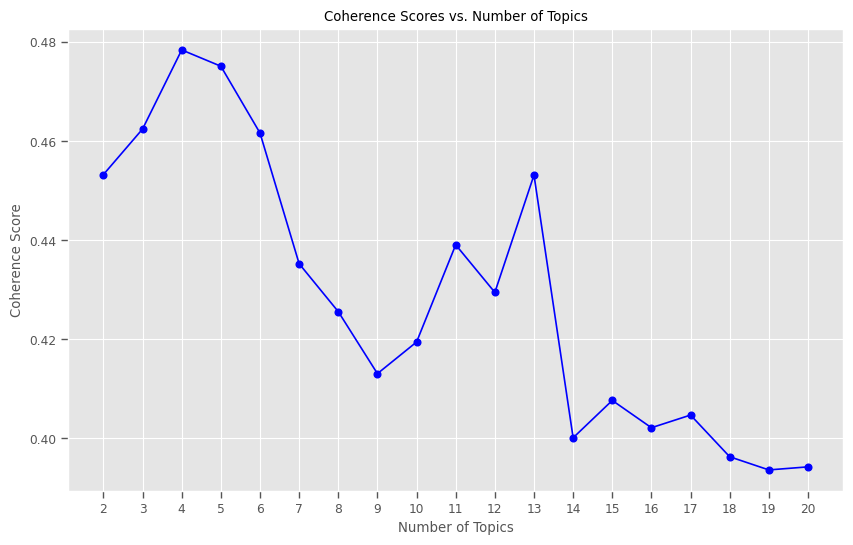

In [23]:
# Plotting coherence scores
plt.figure(figsize=(10, 6))
plt.plot(topics_range, coherence_scores, marker='o', color='b')
plt.title('Coherence Scores vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(topics_range)
plt.grid(True)
plt.savefig('topics_coherence.png')
plt.show()